# Human lncRNA Classification

This notebook trains a mRNA/lncRNA classification model in the standard Genomic-ULMFiT way.

First we fine tune a human genome language model on the lncRNA dataset. Experimentally I found using the full sequence dataset (as opposed to the dataset selected for sequences between 200 and 1000 bp) produced better classification results.

Then we use the fine tuned language model to initialize the classification model. I found experimentally that training the classification model on the size selected sequence dataset produced better results on the test set.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')

# LM Fine Tune

In [5]:
classification_df = pd.read_csv(path/'lncRNA_data2.csv')

In [6]:
classification_df.head()

,Sequence,Target,set
0,AGACCGCGGTGACGTCTCCACCGCGCCAAACTCACTGAAAATCAAA...,mRNA,train
1,TAGCACACATTTACGCTCGCCTGCCGCGGGCCGCTCTCCGTGCTGG...,mRNA,train
2,CCCCTCGCGCCGGGAGGAGCTGGCGGCGAGCGCCGAGCCGGGCGCG...,mRNA,train
3,GGCGGGGCGCGGCGGTTCCGGCCCAGCCATGGCGGACGAGGCCCCG...,mRNA,train
4,AGTCCTGAGTGCATGCTCTGCGGTCTGGGGTCACCTGGGGTGCTTA...,mRNA,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']
test_challenge = classification_df[classification_df.set == 'test_challenge']

In [8]:
voc = np.load(path/'human_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [10]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=800, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Target', vocab=model_vocab)

In [13]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [14]:
learn = get_model_LM(data, drop_mult, config)

In [15]:
learn = learn.to_fp16(dynamic=True);
learn.load('human_3m1s2');

In [16]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(65, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(65, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=65, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


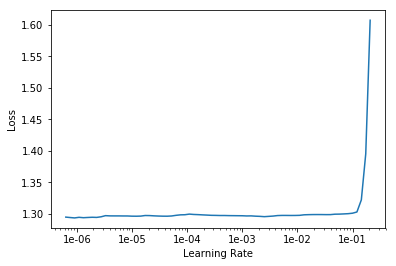

In [21]:
learn.lr_find()
learn.recorder.plot()

# Training

In [22]:
learn.fit_one_cycle(4, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.262970,1.258472,0.408445,34:47
1,1.260460,1.250193,0.413762,34:44
2,1.248792,1.238645,0.421032,34:30
3,1.235858,1.232850,0.424513,35:02


In [23]:
learn.save('lncRNA_L_3m1s')
learn.save_encoder('lncRNA_L_3m1s_enc')

In [18]:
learn.load('lncRNA_L_3m1s');
learn = learn.to_fp16(dynamic=True);

In [21]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.243052,1.230586,0.425785,35:00
1,1.226494,1.223970,0.429681,34:54
2,1.222690,1.221590,0.431052,34:56


In [22]:
learn.save('lncRNA_L_3m1s2')
learn.save_encoder('lncRNA_L_3m1s2_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'lncRNA_data.csv')

In [6]:
classification_df.head()

,Sequence,Target,set
0,GCTCAGCATTTGGGGACGCTCTCAGCTCTCGGCGCACGGCCCAGGT...,mRNA,train
1,GTGACGCGCAAGCCTGGGCCGCTCCTCCTTCCCTCACCCGACGGCC...,mRNA,train
2,ATAGGTATGATCTCGTGAAATCTTGAGAGAAACTGAATGACGAATG...,mRNA,train
3,AGATTCAGGCGTGTAAACCAGCCGGAGCGGCGCGGCAGCGGCAGGA...,mRNA,train
4,GTAGAGGGCTGTACCTTTTTGGCGCTGTGGAAGCCGTTGCTGTGCT...,mRNA,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']
test_challenge = classification_df[classification_df.set == 'test_challenge']

In [8]:
voc = np.load(path/'human_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [10]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Target', bs=64, chunksize=80000)

In [13]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

There are many long sequences in the test set. For this reason, it is important to pass a `max_len` value that is comparable to the longest sequence length in the test set

In [14]:
learn = get_model_clas(data_clas, drop_mult, clas_config, max_len=4000*70)

In [15]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(65, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(65, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, a

In [17]:
learn.load_encoder('lncRNA_L_3m1s2_enc')
learn = learn.to_fp16(dynamic=True);
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


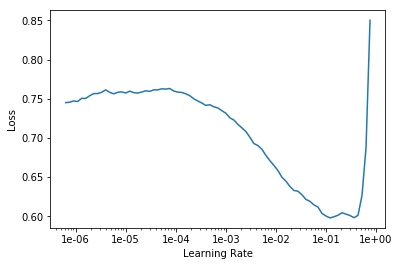

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.393351,0.306814,0.870655,02:45
1,0.394772,0.242637,0.906984,02:44
2,0.369200,0.251085,0.903226,02:47


In [20]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.323380,0.280071,0.886627,03:51
1,0.290529,0.259989,0.898528,03:50
2,0.265366,0.245208,0.909490,03:55


In [21]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.238785,0.238056,0.911369,05:31
1,0.210731,0.200457,0.930473,05:23
2,0.203988,0.195101,0.930160,05:19


In [22]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.191139,0.206711,0.925462,06:52
1,0.182357,0.198737,0.931726,07:00
2,0.171851,0.190752,0.934857,06:43


In [23]:
learn.save('tmp_class_L3')

I found that this point lowering dropout and training a little bit more gave better results. However too much additional training quickly led to overfitting

In [14]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.3

In [15]:
learn = get_model_clas(data_clas, drop_mult, clas_config, max_len=600*70)

In [16]:
learn.load('tmp_class_L3');
learn = learn.to_fp16(dynamic=True);

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.143060,0.182177,0.940182,06:43
1,0.136384,0.181949,0.938929,06:41


In [22]:
learn.save('lncRNA_clas_3m1s')

# Test Set Performance

Prediction on the test set. The test set contains a few extremely long (~15000 bp) sequences. During the testing process, all sequences in a batch must have the same length. fastai handles this by font padding shorter sequences. This dataset contains a handful of extremely long sequences (~15000 bp) while most sequences are around ~2000 bp. If a long sequence is batches with an average sequence, the shorter sequence gets several thousand tokens of padding. This leads to worse classification performance.

For this reason, I set the batch size to 2 for inference. This prevents sequences with a long length difference from being batched together.

In [16]:
learn.load('lncRNA_clas_3m1s');

In [17]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df.sample(1000), test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Target', bs=2, chunksize=100000)
learn.data = data_clas

In [19]:
get_scores(learn)

Accuracy: 0.963
False Positives: 0.024
False Negatives: 0.013
Recall: 0.974
Precision: 0.9530332681017613
Specificity: 0.952
MCC: 0.9262241733782193


# Challenge Test Set Performance

Prediction on the challenge test set

In [20]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df.sample(1000), test_challenge, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Target', bs=2, chunksize=100000)
learn.data = data_clas

In [21]:
get_scores(learn)

Accuracy: 0.9079079079079079
False Positives: 0.028028028028028028
False Negatives: 0.06406406406406406
Recall: 0.8717434869739479
Precision: 0.9395248380129589
Specificity: 0.944
MCC: 0.817929740295247
